# Land use and land cover classification with EuroSAT and fast.ai

In this notebook we want to demonstrate the training of a CNN with the [EuroSAT](https://github.com/phelber/EuroSAT) RGB dataset and the [fast.ai](https://fast.ai) deep learning library. The EuroSAT dataset is based on Sentinel 2 data and  consists of 10 classes.

In [1]:
%matplotlib inline

In [2]:
from fastai.vision import *
from pathlib import Path
import io
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import requests
import zipfile

In [3]:
DATASET_URL = 'http://madm.dfki.de/files/sentinel/EuroSAT.zip'
uploaded = requests.get(DATASET_URL, stream=True)
zipFile = zipfile.ZipFile(io.BytesIO(uploaded.content), 'r')
zipFile.extractall()

In [4]:
PATH = Path('.')
train_path = PATH/'2750' # dataset is extracted into directory 2750

# Modeling

A `DataBunch` object contains training, validation and optionally test data with the associated images and labels. With `valid_pct` we set the percentage of our data set that we want to use for validation. `size` determines the size of the images we want to work with. Our dataset uses 64 by 64 images.

In [5]:
np.random.seed(42)
data = ImageDataBunch.from_folder(train_path, train='.', valid_pct=0.25, ds_tfms=get_transforms(), size=64)

In [6]:
data.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

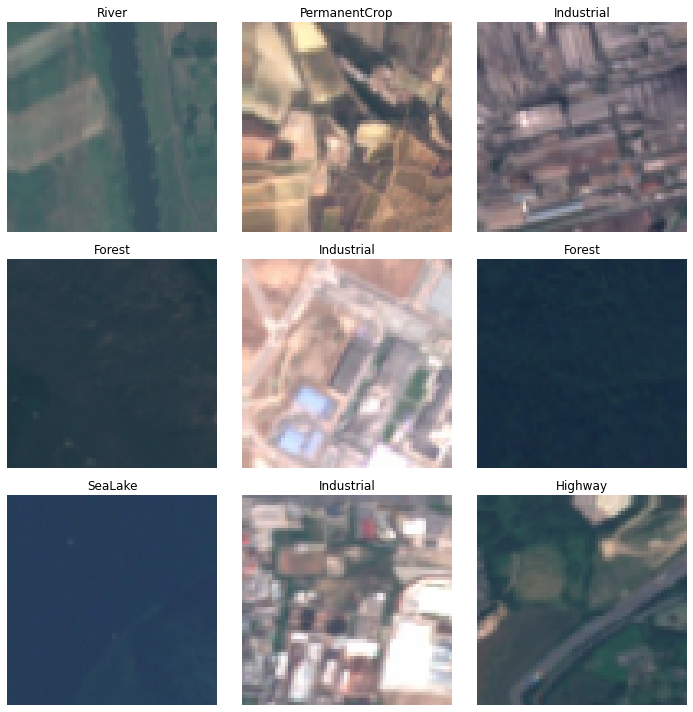

In [7]:
data.show_batch(rows=3, figsize=(10,10))

We use a CNN learner with a ResNet-50 architecture as the paper claims the highest classification accuracy for it and train it for 4 epochs. The model is pre-trained on the ImageNet dataset and we will adapt it to our EuroNET dataset. This approach is called transfer learning and enables us to train our model in a fraction of time. 

In [8]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [9]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.617731,0.405612,0.130519,00:52
1,0.403966,0.241221,0.076889,00:51
2,0.315209,0.190630,0.065333,00:51
3,0.218181,0.171387,0.059259,00:50


In [10]:
learn.save('learn-1')

In [11]:
interpretation = ClassificationInterpretation.from_learner(learn)

With `plot_top_losses` we can find out the images with the highest loss that the model predicts wrong. With `most_confused` we see the combinations of actual and predicted that we classified wrong the most often. We see that our model has a problem with highways that were classified as rivers and vice versa.

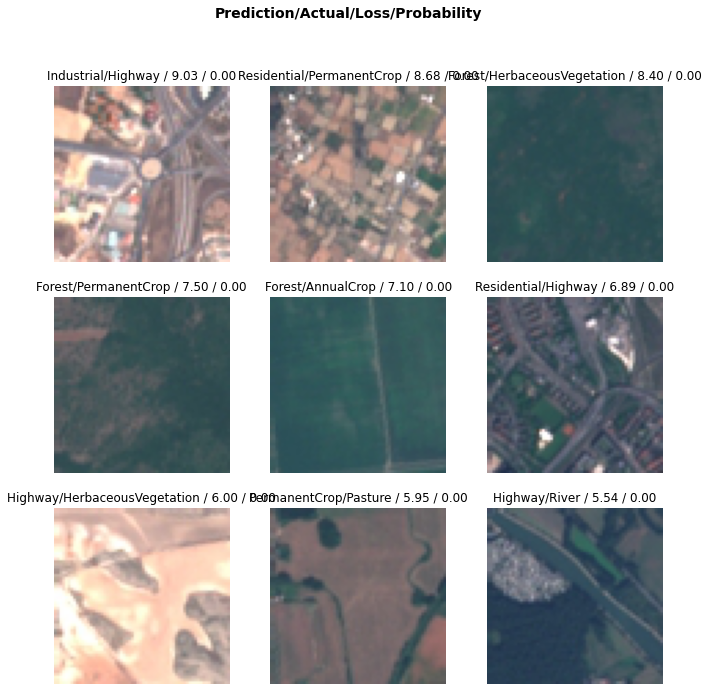

In [12]:
interpretation.plot_top_losses(9, figsize=(11,11))

In [13]:
interpretation.most_confused(min_val=5)

[('River', 'Highway', 45),
 ('Pasture', 'Forest', 28),
 ('AnnualCrop', 'PermanentCrop', 27),
 ('HerbaceousVegetation', 'Forest', 24),
 ('PermanentCrop', 'HerbaceousVegetation', 23),
 ('HerbaceousVegetation', 'PermanentCrop', 21),
 ('Industrial', 'Residential', 20),
 ('Highway', 'River', 19),
 ('Highway', 'PermanentCrop', 16),
 ('PermanentCrop', 'Residential', 13),
 ('HerbaceousVegetation', 'Residential', 11),
 ('SeaLake', 'Forest', 11),
 ('Pasture', 'HerbaceousVegetation', 9),
 ('PermanentCrop', 'AnnualCrop', 8),
 ('River', 'AnnualCrop', 8),
 ('AnnualCrop', 'Pasture', 7),
 ('HerbaceousVegetation', 'Pasture', 6),
 ('AnnualCrop', 'River', 5),
 ('Highway', 'AnnualCrop', 5),
 ('Highway', 'Residential', 5),
 ('Industrial', 'Highway', 5),
 ('Pasture', 'AnnualCrop', 5),
 ('Residential', 'Industrial', 5)]

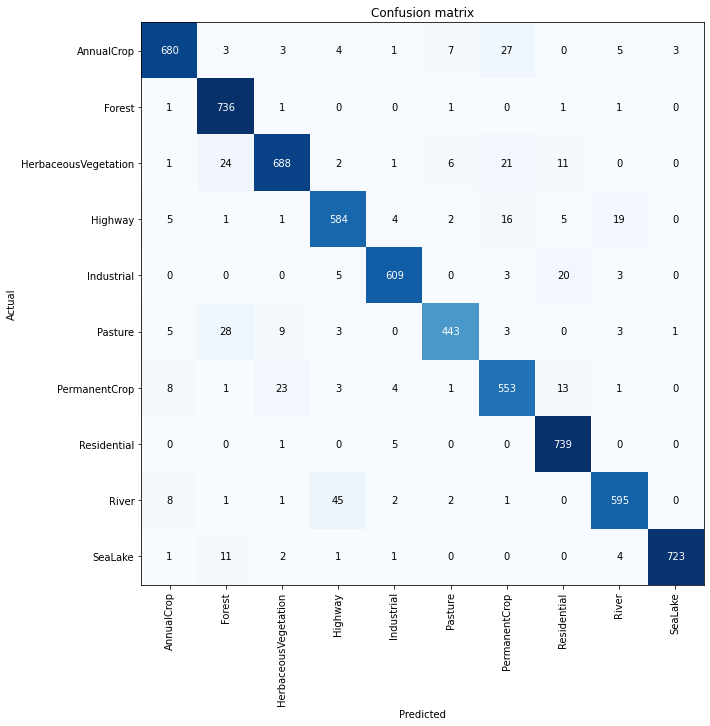

In [14]:
interpretation.plot_confusion_matrix(figsize=(10,10))

We have just trained the head of the model. Now we unfreeze the layers of the backbone and fine-tune the whole model to get to a higher accuracy.

In [15]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.184550,0.123690,0.043556,00:53


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.31E-05


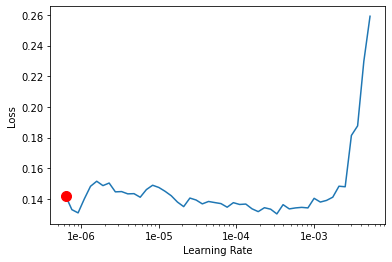

In [16]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [17]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=6.31e-7)

epoch,train_loss,valid_loss,error_rate,time
0,0.134892,0.121850,0.042667,00:53
1,0.126067,0.108608,0.036148,00:53


# Classification

Now we classify some unseen samples.

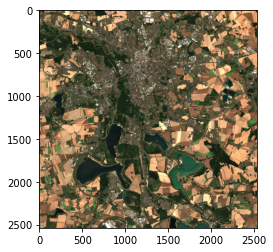

In [18]:
out_dir = Path('out')
img = rasterio.open(out_dir/'T32UQB_20190726T102031_RGB_8bit.tif').read()/255
show(img)

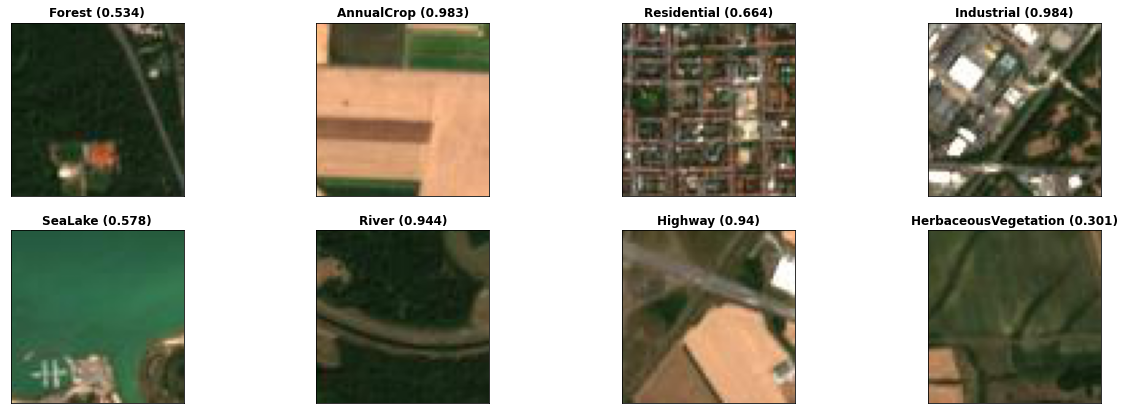

In [19]:
sample_origin_pairs = [(1000, 1000),
                       (2300, 2300),
                       (900, 1090),
                       (920, 1275),
                       (1880, 1662),
                       (335, 460),
                       (35, 1400),
                       (2015, 2015)]

imgs = []
for (x, y) in sample_origin_pairs:
  imgs.append(img[:, x:x+64, y:y+64])
np_imgs = np.stack(imgs)

fig = plt.figure(figsize=(21,7))
for i in range(np_imgs.shape[0]):
    axe = fig.add_subplot(2, 4, 1 + i)
    plt.setp(axe, xticks=[], yticks=[])
    prediction = learn.predict(Image(torch.from_numpy(np_imgs[i]).float()))
    probability = prediction[2][prediction[1].item()].item()
    show(np_imgs[i], ax=axe, title='{} ({})'.format(prediction[0], round(probability, 3)))    



